# Time Series Forecasting using Gaussian Process Regression

In [1]:
%matplotlib inline

# ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy

# set font scale and style
plt.rcParams.update({'font.size': 18})

# gpr 
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
# import custom class
%run -i '../src/helper/ts.py'

In [3]:
# instantiate the class
fxn = TimeSeriesForecasting()

# Load  data

In [4]:
ts = pd.read_csv('../data/collision_ts_month.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date', 'summer_ind'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (228, 11)


,fatality_rate,p_isev_Fatality,p_isev_Injury,p_isev_No Injury,conf_ind_head-on,conf_ind_not-head-on,c_vehs,c_hour,p_age,year,month
date,,,,,,,,,,,
1999-01-01,0.012911,163.0,164.0,89.0,152.0,281.0,2.042258,13.511338,35.239035,1999,1
1999-02-01,0.018163,196.0,176.0,97.0,139.0,343.0,2.006859,13.499924,35.102478,1999,2
1999-03-01,0.020982,219.0,250.0,122.0,149.0,469.0,2.028966,13.507759,34.717830,1999,3
1999-04-01,0.015418,190.0,154.0,83.0,82.0,356.0,2.041576,13.890340,34.662779,1999,4
1999-05-01,0.017953,266.0,248.0,99.0,114.0,523.0,2.037239,13.851641,34.548825,1999,5


## Create a test  set
We must split the dataset into training and test (out-of-sample) set. We have chosen the test set as the last year's observations (i.e. 2017).

In [5]:
train_start, train_end = '1999-01-01','2014-12-01'
test_start, test_end = '2014-01-01', '2017-12-01'

X_train = ts.drop('fatality_rate', axis =1)[train_start: train_end]
y_train = ts['fatality_rate'][train_start: train_end]

X_test = ts.drop('fatality_rate', axis =1)[test_start: test_end]
y_test = ts['fatality_rate'][test_start: test_end]

## Standardization

In [21]:
# standardization
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Gaussian Process Regression (GPR)

In [22]:
# train gpr
kernel = RBF(length_scale = np.ones(X_train.shape[1], )) + WhiteKernel(noise_level=0.5)
gpr = GPR(kernel=kernel, n_restarts_optimizer=0, normalize_y=True, random_state=42)
gpr.fit(X_train_scaled, y_train)

# make prediction
yhat, std = gpr.predict(X_test_scaled, return_std=True)

## Performance measures (error metrics)

In [23]:
fxn.error_metrics(y_test, yhat)

{'MAE = 0.001', 'MAPE = 6.135', 'RMSE = 0.001', 'R^2 = 0.827', 'WMAPE = 5.542'}

In [24]:
yhat[yhat<0] = 0

ylow = yhat -2*std
ylow[ylow<0] = 0

yhigh = yhat + 2*std
yhigh[yhigh<0] = 0

results = pd.DataFrame()
results['yhat'] = yhat
results['ylow'] = ylow
results['yhigh'] = yhigh
results.index = y_test.index

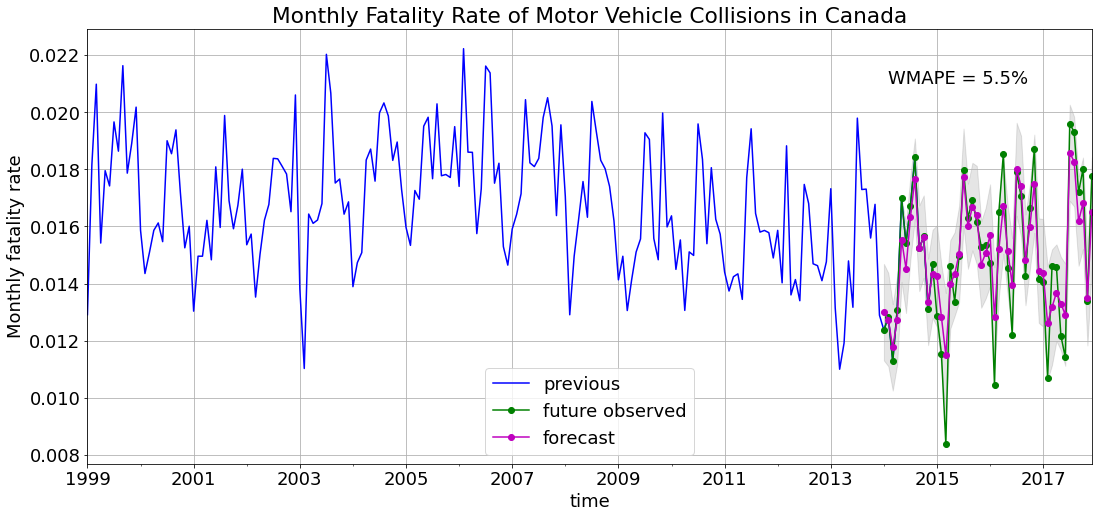

In [25]:
plt.figure(figsize = (18,8))

y_train.plot(label = 'previous', color = 'b')
y_test.plot(label = 'future observed', marker = 'o', color = 'g')
results['yhat'].plot(label = 'forecast', marker = 'o', color = 'm')

plt.fill_between(results.index, results['ylow'], results['yhigh'], color='k', alpha=0.1)
plt.xlabel('time')
plt.text('2014-02-01', 0.021, "WMAPE = 5.5%")
plt.grid(True)
plt.ylabel('Monthly fatality rate')
plt.title('Monthly Fatality Rate of Motor Vehicle Collisions in Canada')
plt.legend()
plt.savefig('../images/gpr.png')
plt.show()

## Model Diagnostics

## 1. Residuals of the test set 
The residuals plots displayed below show that the standardized residuals fall between -3 and 3, which suggests the residuals are normally distributed.  The sample autocorrelation function (ACF) of the residuals shows that the residuals are approximately uncorrelated, behaving a white noise.

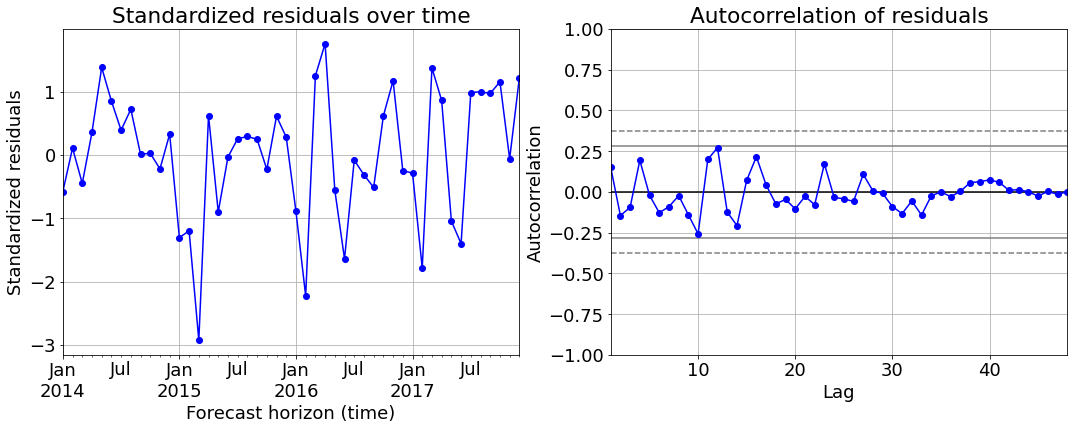

In [26]:
plt.figure(figsize = (18,6))
residual = y_test-results['yhat']
rstandard = (residual-np.mean(residual))/np.std(residual)
mape = np.abs(residual)*100/np.abs(y_test)

plt.subplot(121)
rstandard.plot(color = 'b', marker = 'o')
plt.grid(True)
plt.xlabel('Forecast horizon (time)')
plt.ylabel('Standardized residuals')
plt.title('Standardized residuals over time')

plt.subplot(122)
pd.plotting.autocorrelation_plot(pd.Series(residual), color = 'b', marker = 'o')
plt.title('Autocorrelation of residuals')
# plt.savefig('../images/figdi.png')
plt.show()

## 2. Ljung-Box test

A good forecasting model will have zero correlation between its residuals. Correlation in residuals means that some information were left out which should have been used in forecasting.

We use the Ljung-Box test to check if the residuals (absolute percent error) from the time series model resemble white noise (i.e., zero autocorrelation). The null hypothesis states that the residuals are independently and identically distributed, that is the errors are uncorrelated. Therefore, a p-value greater than the type I error $\alpha = 0.05$ means that we do not have enough information (or statistically significant evidence) to reject the null hypothesis. However, this does not mean that the forecasting model cannot be improved.

The p-values of the Ljung-Box test for various lags show that some 
of the Ljung-Box test p-values are larger than $\alpha = 0.05$.

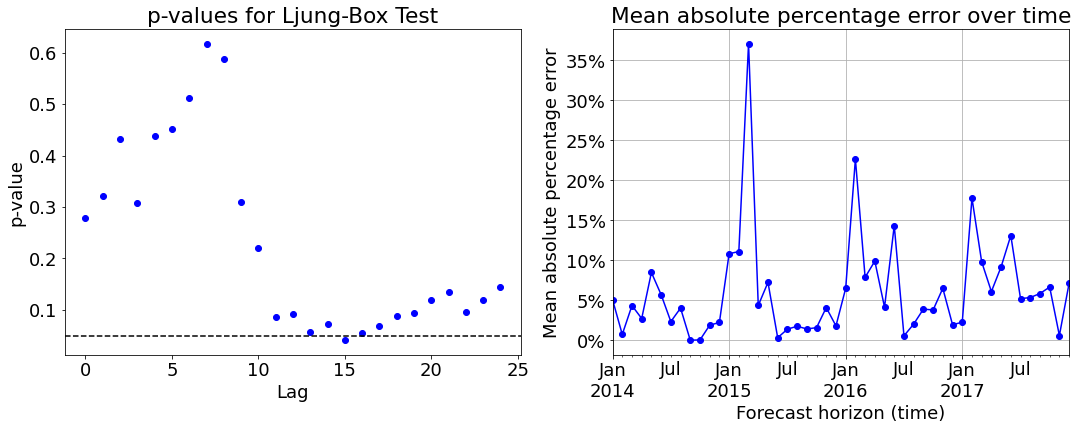

In [28]:
plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(acorr_ljungbox(residual, lags = 25)[1], 'o', color = 'b')
plt.axhline(y=0.05,linestyle= '--', color = 'k')
plt.ylabel('p-value')
plt.xlabel('Lag')
# plt.ylim([0,1])
plt.title('p-values for Ljung-Box Test')

plt.subplot(122)
mape.plot(color = 'b', marker = 'o')
plt.grid(True)
plt.xlabel('Forecast horizon (time)')
plt.ylabel('Mean absolute percentage error')
plt.title('Mean absolute percentage error over time')
label = ['0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%']
plt.yticks(np.arange(0,36,5),label)
# plt.savefig('../images/figlb.png')
plt.show()